In [3]:
import Pkg
Pkg.add("Plots")
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("HypothesisTests")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [89]:
import CSV

using DataFrames

get_dataframe() = begin
    CSV.read(read(`./image/amm results_to_csv.sc`), DataFrame)
end

df = get_dataframe()

,errors,latency,name,operationCount,repeatIdx,serverCount,threadCount
,Int64,Float64?,String15,Int64?,Int64,Int64,Int64?
1,0,9837.88,etcd,10000,1,3,1
2,0,40594.5,etcd,100000,1,3,100
3,0,161950.0,etcd,100000,1,3,1000
4,0,43795.2,etcd,100000,1,3,125
5,0,44451.0,etcd,100000,1,3,150
6,0,51983.5,etcd,100000,1,3,175
7,0,30001.5,etcd,40000,1,3,20
8,0,55876.8,etcd,100000,1,3,200
9,0,60216.8,etcd,100000,1,3,225


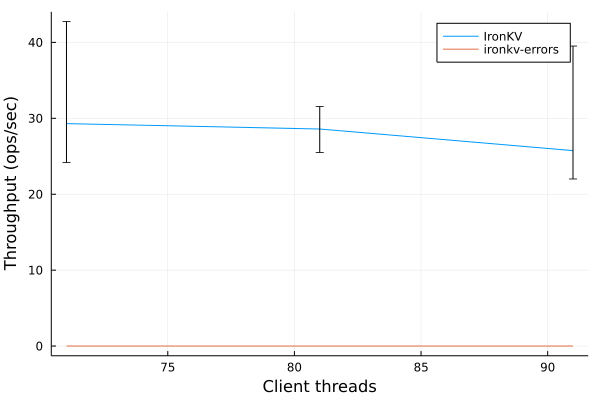

In [88]:
using Plots
using DataFrames
using Statistics

# df = get_dataframe()

begin
    df_ironkv = groupby(df, [:name, :workload, :serverCount])[("ironkv", "workloada", 7)]
    
    by_threads = groupby(df_ironkv, :threadCount)
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot(stats[:, :threadCount], data,
        xguide = "Client threads",
        yguide = "Throughput (ops/sec)",
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "IronKV")
    
    plot!(stats[:, :threadCount], stats[:, :errors_median], label = "ironkv-errors")
end

In [65]:
    df_ironkv = groupby(df, [:name, :workload, :serverCount])[("ironkv", "workloada", 3)]

,errors,latency,name,operationCount,repeatIdx,serverCount,threadCount
,Int64,Float64?,String15,Int64?,Int64,Int64,Int64?
1,0,48174.5,ironkv,10000,1,3,1
2,0,1.43409e5,ironkv,10000,1,3,101
3,0,1.12736e5,ironkv,10000,1,3,11
4,0,1.88619e5,ironkv,10000,1,3,121
5,0,2.10203e5,ironkv,10000,1,3,151
6,0,1.08341e5,ironkv,10000,1,3,21
7,0,84462.1,ironkv,10000,1,3,31
8,0,124044.0,ironkv,10000,1,3,41
9,0,1.61721e5,ironkv,10000,1,3,51


In [47]:
using DataFrames
using Statistics
import HypothesisTests

# df = get_dataframe()

begin
    df_ironkv = groupby(df, [:name, :workload, :serverCount])[("ironkv", "workloada", 3)]
    
    by_threads = groupby(df_ironkv, :threadCount)
    
    threads_11 = by_threads[(11,)][!, :throughput]
    threads_36 = by_threads[(36,)][!, :throughput]
    
    HypothesisTests.UnequalVarianceTTest(threads_11, threads_36)
end

LoadError: KeyError: key (36,) not found

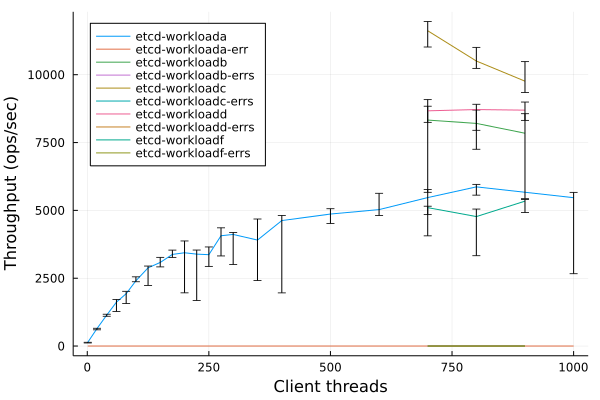

In [90]:
using Plots
using DataFrames
using Statistics

# df = get_dataframe()

begin
    df_etcd = groupby(df, [:name, :workload, :serverCount])[("etcd", "workloada", 3)]
    sort!(df_etcd, [:threadCount])
    
    by_threads = groupby(df_etcd, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot(stats[:, :threadCount], data,
        xguide = "Client threads",
        yguide = "Throughput (ops/sec)",
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "etcd-workloada",
        legend=:topleft)
    
    plot!(stats[:, :threadCount], stats[:, :errors_median], label = "etcd-workloada-err")
end

begin
    df_etcd = groupby(df, [:name, :workload, :serverCount])[("etcd", "workloadb", 3)]
    sort!(df_etcd, [:threadCount])
    
    by_threads = groupby(df_etcd, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "etcd-workloadb")
    
    plot!(stats[:, :threadCount], stats[:, :errors_median], label = "etcd-workloadb-errs")
end

begin
    df_etcd = groupby(df, [:name, :workload, :serverCount])[("etcd", "workloadc", 3)]
    sort!(df_etcd, [:threadCount])
    
    by_threads = groupby(df_etcd, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "etcd-workloadc")
    
    plot!(stats[:, :threadCount], stats[:, :errors_median], label = "etcd-workloadc-errs")
end

begin
    df_etcd = groupby(df, [:name, :workload, :serverCount])[("etcd", "workloadd", 3)]
    sort!(df_etcd, [:threadCount])
    
    by_threads = groupby(df_etcd, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "etcd-workloadd")
    
    plot!(stats[:, :threadCount], stats[:, :errors_median], label = "etcd-workloadd-errs")
end

begin
    df_etcd = groupby(df, [:name, :workload, :serverCount])[("etcd", "workloadf", 3)]
    sort!(df_etcd, [:threadCount])
    
    by_threads = groupby(df_etcd, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "etcd-workloadf")
    
    plot!(stats[:, :threadCount], stats[:, :errors_median], label = "etcd-workloadf-errs")
end

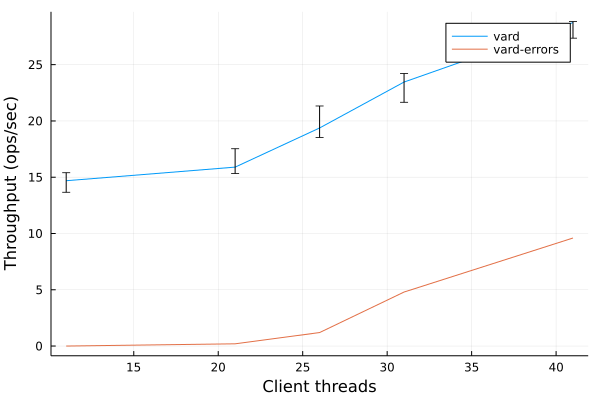

In [91]:
using Plots
using DataFrames
using Statistics

# df = get_dataframe()

begin
    df_vard = groupby(df, [:name, :workload, :serverCount])[("vard", "workloada", 3)]
    sort!(df_vard, [:threadCount])
    
    by_threads = groupby(df_vard, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => mean)
    
    data = stats[:, :throughput_median]
    
    plot(stats[:, :threadCount], data,
        xguide = "Client threads",
        yguide = "Throughput (ops/sec)",
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "vard")
    
    plot!(stats[:, :threadCount], stats[:, :errors_mean], label = "vard-errors")
end

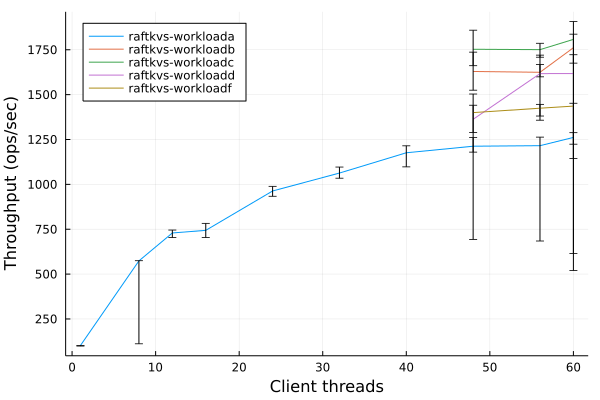

In [152]:
using Plots
using DataFrames
using Statistics

# df = get_dataframe()

begin
    df_raftkvs = groupby(df, [:name, :workload, :serverCount])[("raftkvs", "workloada", 3)]
    sort!(df_raftkvs, [:threadCount])
    
    by_threads = groupby(df_raftkvs, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot(stats[:, :threadCount], data,
        xguide = "Client threads",
        yguide = "Throughput (ops/sec)",
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "raftkvs-workloada",
        legend=:topleft)
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "raftkvs-workloada-err")
end

begin
    df_raftkvs = groupby(df, [:name, :workload, :serverCount])[("raftkvs", "workloadb", 3)]
    sort!(df_raftkvs, [:threadCount])
    
    by_threads = groupby(df_raftkvs, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "raftkvs-workloadb")
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "raftkvs-workloadb-err")
end

begin
    df_raftkvs = groupby(df, [:name, :workload, :serverCount])[("raftkvs", "workloadc", 3)]
    sort!(df_raftkvs, [:threadCount])
    
    by_threads = groupby(df_raftkvs, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "raftkvs-workloadc")
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "raftkvs-workloadc-err")
end

begin
    df_raftkvs = groupby(df, [:name, :workload, :serverCount])[("raftkvs", "workloadd", 3)]
    sort!(df_raftkvs, [:threadCount])
    
    by_threads = groupby(df_raftkvs, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "raftkvs-workloadd")
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "raftkvs-workloadd-err")
end

begin
    df_raftkvs = groupby(df, [:name, :workload, :serverCount])[("raftkvs", "workloadf", 3)]
    sort!(df_raftkvs, [:threadCount])
    
    by_threads = groupby(df_raftkvs, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "raftkvs-workloadf")
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "raftkvs-workloadf-err")
end

In [151]:
df_raftkvs = groupby(df, [:name, :workload, :serverCount])[("raftkvs", "workloadb", 3)]

,errors,name,operationCount,repeatIdx,serverCount,threadCount,throughput
,Int64,String15,Int64?,Int64,Int64,Int64?,Float64?
1,0,raftkvs,10000,1,3,48,1519.7
2,0,raftkvs,10000,2,3,48,1532.1
3,0,raftkvs,10000,3,3,48,1629.0
4,0,raftkvs,10000,4,3,48,1741.8
5,0,raftkvs,10000,5,3,48,1728.9
6,0,raftkvs,10000,1,3,56,1604.7
7,0,raftkvs,10000,2,3,56,1624.4
8,0,raftkvs,10000,3,3,56,1715.0
9,0,raftkvs,10000,4,3,56,1723.3


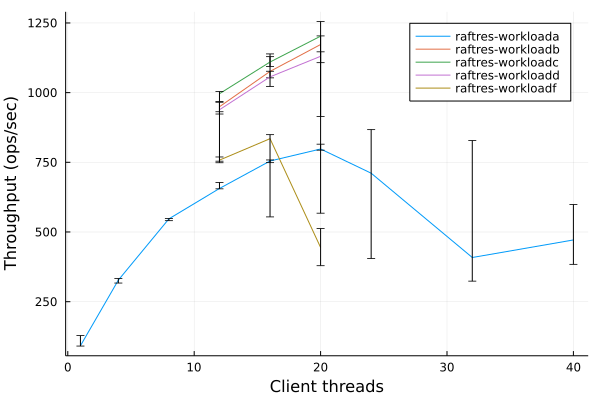

In [154]:
using Plots
using DataFrames
using Statistics

# df = get_dataframe()

begin
    df_raftres = groupby(df, [:name, :workload, :serverCount])[("raftres", "workloada", 3)]
    sort!(df_raftres, [:threadCount])
    
    by_threads = groupby(df_raftres, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot(stats[:, :threadCount], data,
        xguide = "Client threads",
        yguide = "Throughput (ops/sec)",
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "raftres-workloada",
        legend=:topright)
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "raftres-workloada-err")
end

begin
    df_raftres = groupby(df, [:name, :workload, :serverCount])[("raftres", "workloadb", 3)]
    sort!(df_raftres, [:threadCount])
    
    by_threads = groupby(df_raftres, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "raftres-workloadb")
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "raftres-workloadb-err")
end

begin
    df_raftres = groupby(df, [:name, :workload, :serverCount])[("raftres", "workloadc", 3)]
    sort!(df_raftres, [:threadCount])
    
    by_threads = groupby(df_raftres, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "raftres-workloadc")
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "raftres-workloadc-err")
end

begin
    df_raftres = groupby(df, [:name, :workload, :serverCount])[("raftres", "workloadd", 3)]
    sort!(df_raftres, [:threadCount])
    
    by_threads = groupby(df_raftres, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "raftres-workloadd")
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "raftres-workloadd-err")
end

begin
    df_raftres = groupby(df, [:name, :workload, :serverCount])[("raftres", "workloadf", 3)]
    sort!(df_raftres, [:threadCount])
    
    by_threads = groupby(df_raftres, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "raftres-workloadf")
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "raftres-workloadd-err")
end

In [155]:
df_raftres = groupby(df, [:name, :workload, :serverCount])[("raftres", "workloadf", 3)]

,errors,name,operationCount,repeatIdx,serverCount,threadCount,throughput
,Int64,String15,Int64?,Int64,Int64,Int64?,Float64?
1,0,raftres,10000,1,3,12,755.4
2,0,raftres,10000,2,3,12,743.8
3,0,raftres,10000,3,3,12,758.0
4,0,raftres,10000,4,3,12,776.6
5,0,raftres,10000,5,3,12,757.9
6,0,raftres,10000,1,3,16,432.4
7,0,raftres,10000,2,3,16,853.3
8,0,raftres,10000,3,3,16,834.8
9,0,raftres,10000,4,3,16,843.1


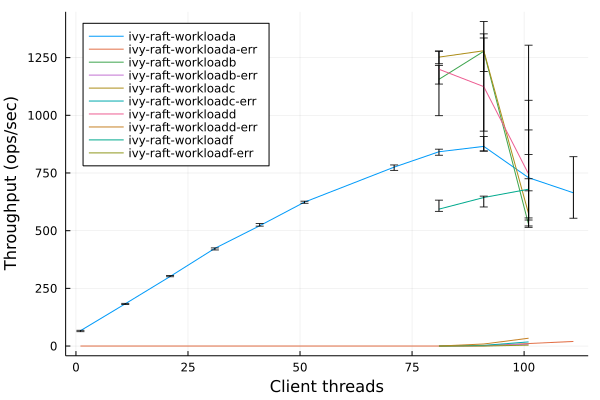

In [163]:
using Plots
using DataFrames
using Statistics

# df = get_dataframe()

begin
    df_ivyraft = groupby(df, [:name, :workload, :serverCount])[("ivy-raft", "workloada", 3)]
    sort!(df_ivyraft, [:threadCount])
    
    by_threads = groupby(df_ivyraft, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot(stats[:, :threadCount], data,
        xguide = "Client threads",
        yguide = "Throughput (ops/sec)",
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "ivy-raft-workloada",
        legend = :topleft)
    
    plot!(stats[:, :threadCount], stats[:, :errors_median], label = "ivy-raft-workloada-err")
end

begin
    df_ivyraft = groupby(df, [:name, :workload, :serverCount])[("ivy-raft", "workloadb", 3)]
    sort!(df_ivyraft, [:threadCount])
    
    by_threads = groupby(df_ivyraft, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "ivy-raft-workloadb")
    
    plot!(stats[:, :threadCount], stats[:, :errors_median], label = "ivy-raft-workloadb-err")
end

begin
    df_ivyraft = groupby(df, [:name, :workload, :serverCount])[("ivy-raft", "workloadc", 3)]
    sort!(df_ivyraft, [:threadCount])
    
    by_threads = groupby(df_ivyraft, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "ivy-raft-workloadc")
    
    plot!(stats[:, :threadCount], stats[:, :errors_median], label = "ivy-raft-workloadc-err")
end

begin
    df_ivyraft = groupby(df, [:name, :workload, :serverCount])[("ivy-raft", "workloadd", 3)]
    sort!(df_ivyraft, [:threadCount])
    
    by_threads = groupby(df_ivyraft, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "ivy-raft-workloadd")
    
    plot!(stats[:, :threadCount], stats[:, :errors_median], label = "ivy-raft-workloadd-err")
end

begin
    df_ivyraft = groupby(df, [:name, :workload, :serverCount])[("ivy-raft", "workloadf", 3)]
    sort!(df_ivyraft, [:threadCount])
    
    by_threads = groupby(df_ivyraft, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot!(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "ivy-raft-workloadf")
    
    plot!(stats[:, :threadCount], stats[:, :errors_median], label = "ivy-raft-workloadf-err")
end

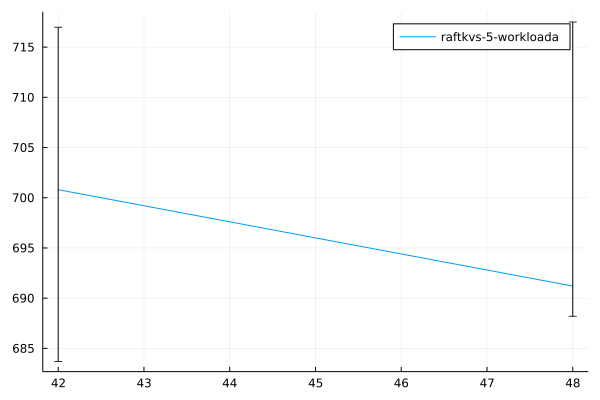

In [38]:
using Plots
using DataFrames
using Statistics

begin
    df_raftkvs = groupby(df, [:name, :workload, :serverCount])[("raftkvs", "workloada", 9)]
    sort!(df_raftkvs, [:threadCount])
    
    by_threads = groupby(df_raftkvs, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "raftkvs-5-workloada")
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "raftkvs-workloadd-err")
end

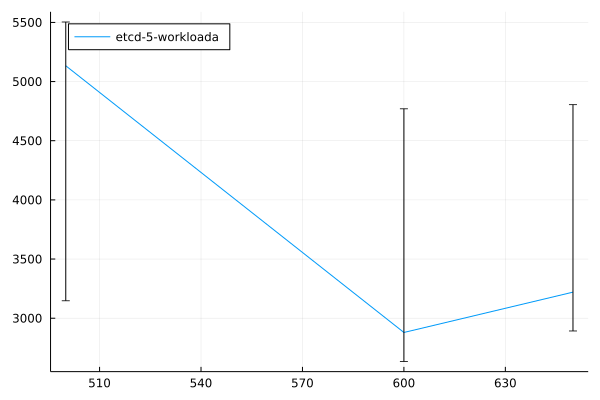

In [37]:
begin
    df_etcd = groupby(df, [:name, :workload, :serverCount])[("etcd", "workloada", 9)]
    sort!(df_etcd, [:threadCount])
    
    by_threads = groupby(df_etcd, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "etcd-5-workloada",
        legend = :topleft)
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "etcd-workloadb-errs")
end

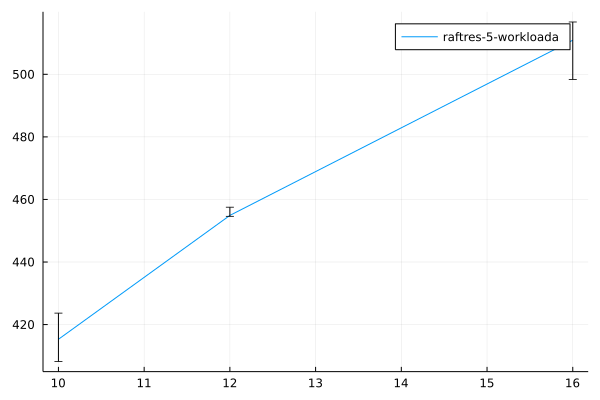

In [39]:
using Plots
using DataFrames
using Statistics

begin
    df_raftres = groupby(df, [:name, :workload, :serverCount])[("raftres", "workloada", 9)]
    sort!(df_raftres, [:threadCount])
    
    by_threads = groupby(df_raftres, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "raftres-5-workloada")
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "raftres-workloadd-err")
end

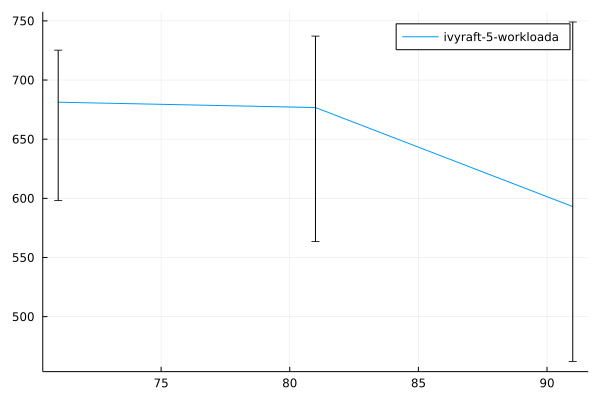

In [40]:
using Plots
using DataFrames
using Statistics

begin
    df_ivy = groupby(df, [:name, :workload, :serverCount])[("ivy-raft", "workloada", 9)]
    sort!(df_ivy, [:threadCount])
    
    by_threads = groupby(df_ivy, :threadCount)
    
    quantile_10th(data) = quantile(data, .1)
    quantile_90th(data) = quantile(data, .9)
    stats = combine(by_threads, :throughput => median, :throughput => quantile_10th, :throughput => quantile_90th, :errors => median)
    
    data = stats[:, :throughput_median]
    
    plot(stats[:, :threadCount], data,
        yerr = (data .- stats[:, :throughput_quantile_10th], stats[:, :throughput_quantile_90th] .- data),
        label = "ivyraft-5-workloada")
    
    # plot!(stats[:, :threadCount], stats[:, :errors_median], label = "ivyraft-workloadd-err")
end